In [1]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


In [2]:
import numpy as np
import matplotlib.pyplot as plt

Traking a 2D robot

We are tracking a robot moving on an x,y coordinate system, the following generates movement data with some noise

In [3]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

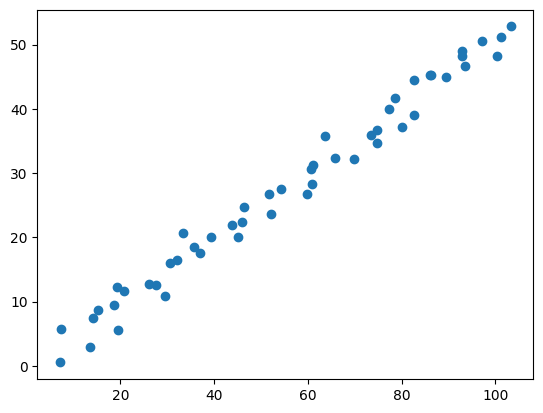

In [4]:
sens = PosSensor(pos=(4, 2), vel=(2, 1), noise_std=2)
pos = np.array([sens.read() for _ in range(50)])
plt.scatter(pos[:, 0], pos[:, 1])

The state includes x,y and their respective velocity, which we assume to be constant. This translates to the following transition equation:

$$
\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}
$$

Filter implementation

In [5]:
from src.classes import KalmanFilterBase

In [6]:
tracker = KalmanFilterBase(4, 2)

transiation equation

In [7]:
dt = 1.
tracker.F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])

process noise matrix: we assume time invariant white noise

In [8]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.      0.     ]
 [0.0005  0.001   0.      0.     ]
 [0.      0.      0.00025 0.0005 ]
 [0.      0.      0.0005  0.001  ]]


controll function, omitted for now

In [9]:
tracker.B = np.zeros((4,4))
tracker.u = np.zeros((4,1))

measurement function: measurement are assumed to be in feet, the function H is translating this to meters

In [10]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

measurement noise matrix

In [11]:
tracker.R = np.array([[5., 0],
                      [0, 5]])

setting the inital position

In [12]:
x = np.array([[0, 0, 0, 0]]).T
P = np.eye(4) * 500.

In [13]:
P

array([[500.,   0.,   0.,   0.],
       [  0., 500.,   0.,   0.],
       [  0.,   0., 500.,   0.],
       [  0.,   0.,   0., 500.]])

In [15]:
tracker.H

array([[3.2808399, 0.       , 0.       , 0.       ],
       [0.       , 0.       , 3.2808399, 0.       ]])